# Zadanie 1 - Strategie dla ryzyka związanego z ceną miedzi

[*********************100%***********************]  1 of 1 completed

Aktualna cena miedzi: 4.80 USD/lb
Oszacowana zmienność roczna: 24.00%
Premia opcyjna: 0.2531 USD/lb (łącznie: 253.09 USD)


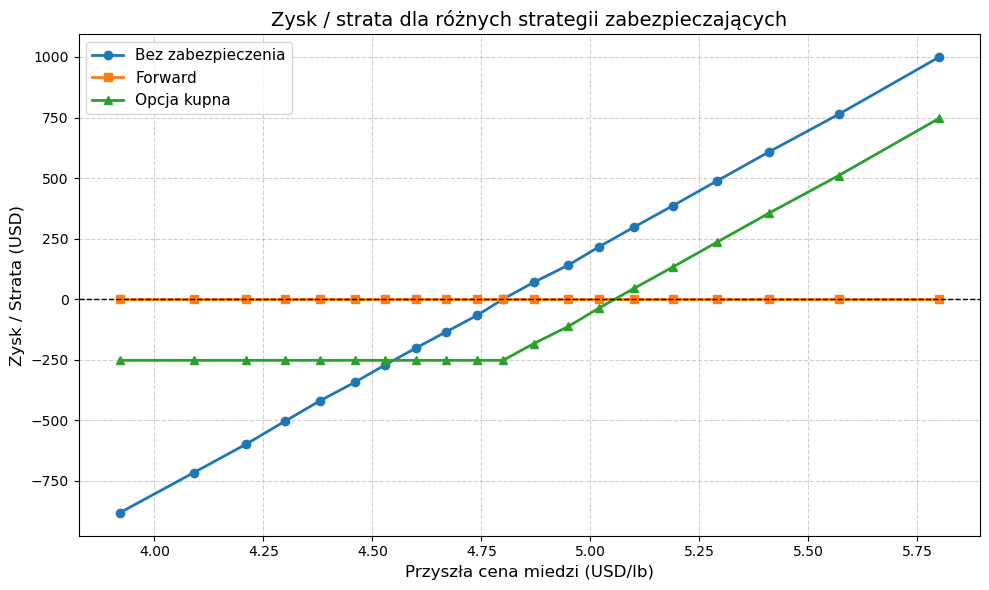


Value at Risk (VaR 95%) – strategia z opcją: -253.09 USD

Tabela strategii:



,Przyszła cena miedzi (USD/lb),Koszt: Bez zabezp. (USD),Zysk/Strata: Bez zabezp. (USD),Koszt: Forward (USD),Zysk/Strata: Forward (USD),Koszt: Opcja kupna (USD),Zysk/Strata: Opcja kupna (USD)
0,3.92,3921.55,-883.45,4805.00,0.00,4551.91,-253.09
1,4.09,4087.72,-717.28,4805.00,0.00,4551.91,-253.09
2,4.21,4205.06,-599.94,4805.00,0.00,4551.91,-253.09
3,4.30,4300.92,-504.08,4805.00,0.00,4551.91,-253.09
4,4.38,4384.87,-420.13,4805.00,0.00,4551.91,-253.09
5,4.46,4461.51,-343.49,4805.00,0.00,4551.91,-253.09
6,4.53,4533.52,-271.48,4805.00,0.00,4551.91,-253.09
7,4.60,4602.66,-202.34,4805.00,0.00,4551.91,-253.09
8,4.67,4670.24,-134.76,4805.00,0.00,4551.91,-253.09
9,4.74,4737.32,-67.68,4805.00,0.00,4551.91,-253.09


In [49]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parametry
ticker = 'HG=F'
notional = 1000  # funty miedzi
T = 90 / 365  # 90 dni
r = 0.0425  # stopa wolna od ryzyka

data = yf.download(ticker, period='6y')['Close']
S0 = data.iloc[-1].item()
log_returns = np.ravel(np.log(data / data.shift(1)).dropna())
sigma = np.std(log_returns) * np.sqrt(252)
print(f'Aktualna cena miedzi: {S0:.2f} USD/lb')
print(f'Oszacowana zmienność roczna: {sigma:.2%}')

# Kwantyle – możliwe przyszłe ceny
quantiles = np.linspace(0.05, 0.95, 20)
future_prices = S0 * np.exp(norm.ppf(quantiles) * sigma * np.sqrt(T) - 0.5 * sigma**2 * T)

# Premia opcyjna
def call_option_price(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

K = S0  # Strike = dzisiejsza cena
call_premium = call_option_price(S0, K, T, r, sigma)
premium_total = call_premium * notional
print(f'Premia opcyjna: {call_premium:.4f} USD/lb (łącznie: {premium_total:.2f} USD)')

# Tworzenie tabeli
rows = []
for price in future_prices:
    # Koszt bez zabezpieczenia
    cost_unhedged = price * notional
    pnl_unhedged = cost_unhedged - S0 * notional

    # Koszt forward (z góry ustalona cena)
    cost_forward = K * notional
    pnl_forward = cost_forward - S0 * notional

    # Koszt z opcją
    cost_option = max(price, K) * notional - premium_total
    pnl_option = cost_option - S0 * notional

    rows.append([
        round(price, 2),
        round(cost_unhedged, 2), round(pnl_unhedged, 2),
        round(cost_forward, 2), round(pnl_forward, 2),
        round(cost_option, 2), round(pnl_option, 2)
    ])

df = pd.DataFrame(rows, columns=[
    'Przyszła cena miedzi (USD/lb)',
    'Koszt: Bez zabezp. (USD)', 'Zysk/Strata: Bez zabezp. (USD)',
    'Koszt: Forward (USD)', 'Zysk/Strata: Forward (USD)',
    'Koszt: Opcja kupna (USD)', 'Zysk/Strata: Opcja kupna (USD)'
])

# Wykres
plt.figure(figsize=(10, 6))
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Bez zabezp. (USD)'], label='Bez zabezpieczenia', marker='o', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Forward (USD)'], label='Forward', marker='s', linewidth=2)
plt.plot(df['Przyszła cena miedzi (USD/lb)'], df['Zysk/Strata: Opcja kupna (USD)'], label='Opcja kupna', marker='^', linewidth=2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Zysk / strata dla różnych strategii zabezpieczających', fontsize=14)
plt.xlabel('Przyszła cena miedzi (USD/lb)', fontsize=12)
plt.ylabel('Zysk / Strata (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

def style_table(df):
    styles = []

    # Białe kontury dla wszystkich komórek i nagłówków
    styles.append({
        'selector': 'th, td',
        'props': [('border', '0.5px solid white')]
    })

    # Gruba biała linia pionowa po pierwszej kolumnie (przyszła cena)
    styles.append({
        'selector': 'td.col0, th.col0',
        'props': [('border-right', '4px solid white')]
    })

    # Grube białe linie pionowe po kolumnach 2 i 4 (0-based)
    styles.append({
        'selector': 'td.col2, th.col2',
        'props': [('border-right', '4px solid white')]
    })
    styles.append({
        'selector': 'td.col4, th.col4',
        'props': [('border-right', '4px solid white')]
    })

    # Pogrubienie nagłówków
    styles.append({
        'selector': 'th',
        'props': [('font-weight', 'bold')]
    })

    return df.style.format(precision=2).set_table_styles(styles)


# Obliczenie VaR dla opcji
pnl_option_all = df['Zysk/Strata: Opcja kupna (USD)'].values
VaR = np.percentile(pnl_option_all, 5)
print(f'\nValue at Risk (VaR 95%) – strategia z opcją: {VaR:.2f} USD')

print('\nTabela strategii:\n')
styled_df = style_table(df)
styled_df

# Inne miary wrażliwości dla strategii z opcją kupna

In [45]:
from scipy.stats import norm
import numpy as np

def option_greeks(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # na 1% zmienności
    theta = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
    theta /= 365  # dzienna theta
    rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100  # na 1% zmiany stopy

    return delta, gamma, vega, theta, rho

# Parametry (przykład)
S = S0  # cena miedzi
K = S0  # strike = cena obecna
T = 30 / 365
r = 0.05
sigma = sigma

delta, gamma, vega, theta, rho = option_greeks(S, K, T, r, sigma)

print(f'Delta: {delta:.4f}')
print(f'Gamma: {gamma:.6f}')
print(f'Vega: {vega:.4f}')
print(f'Theta (dzienna): {theta:.4f}')
print(f'Rho: {rho:.4f}')


Delta: 0.5375
Gamma: 1.201470
Vega: 0.0055
Theta (dzienna): -0.0025
Rho: 0.0020


* **Delta** – wrażliwość ceny opcji na zmianę ceny instrumentu bazowego,
* **Gamma** – wrażliwość delty na zmianę ceny instrumentu bazowego,
* **Vega** – wrażliwość ceny opcji na zmianę zmienności (sigma),
* **Theta** – wrażliwość ceny opcji na upływ czasu,
* **Rho** – wrażliwość ceny opcji na zmianę stopy procentowej.

**Wyjaśnienie:**

* *Delta* bliska 0–1, mówi jak bardzo zmieni się cena opcji jeśli cena miedzi zmieni się o 1 USD.
* *Gamma* informuje, jak szybko zmienia się delta przy zmianie ceny instrumentu.
* *Vega* pokazuje, jak cena opcji zmienia się przy wzroście zmienności o 1 punkt procentowy.
* *Theta* mówi, ile opcji „traci” na wartości każdego dnia (koszt upływu czasu).
* *Rho* pokazuje wrażliwość opcji na zmianę stóp procentowych.

